In [1]:
import pandas as pd
import numpy as np
import math

!pip install sklearn-ts==0.0.5

#Load data

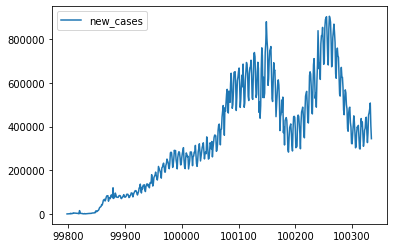

In [2]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [3]:
# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = ['intercept', 'trend', 'log', f'{h}_lag_rolling']
lag_features= []

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek

for lag in [h + i for i in range(14)]:
    dataset[f'{lag}_lag'] = dataset[target].shift(lag)
    lag_features.append(f'{lag}_lag')

dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features + categorical_features + lag_features]
dataset = dataset.dropna()

# Outliers

In [4]:
from sklearn.ensemble import IsolationForest

In [6]:
iso = IsolationForest(random_state=0)
iso.fit(dataset[features])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

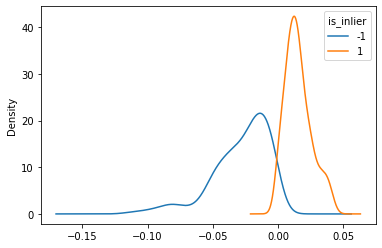

In [15]:
scores = pd.DataFrame({
    'index': dataset.index,
    'is_inlier': iso.predict(dataset[features]), 
    'score': iso.score_samples(dataset[features]) + 0.5
})

pd.pivot_table(scores, index='index', columns='is_inlier', values='score').plot.kde()

# Fourier

In [16]:
from sklearn_ts.features.seasonality import add_fourier_to_X

In [17]:
X_with_fourier = add_fourier_to_X(dataset, periods=[7], N=[1], with_intercept=False)
X_with_fourier.head()

,date,new_cases,intercept,trend,log,14_lag_rolling,year,month,dayofweek,14_lag,15_lag,16_lag,17_lag,18_lag,19_lag,20_lag,21_lag,22_lag,23_lag,24_lag,25_lag,26_lag,27_lag,fourier_sin_7_1,fourier_cos_7_1
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-18,2020-02-18,1882.0,1,27,3.332205,1667.214286,2020,2,1,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0,286.0,98.0,0.0,0.000000,1.000000
2020-02-19,2020-02-19,500.0,1,28,3.367296,1934.714286,2020,2,2,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0,286.0,98.0,0.781831,0.623490
2020-02-20,2020-02-20,560.0,1,29,3.401197,2153.428571,2020,2,3,3160.0,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0,286.0,0.974928,-0.222521
2020-02-21,2020-02-21,629.0,1,30,3.433987,2389.642857,2020,2,4,3593.0,3160.0,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,492.0,0.433884,-0.900969
2020-02-22,2020-02-22,1761.0,1,31,3.465736,2549.785714,2020,2,5,2734.0,3593.0,3160.0,3745.0,4011.0,3100.0,4749.0,2111.0,1692.0,2068.0,589.0,2651.0,809.0,685.0,-0.433884,-0.900969


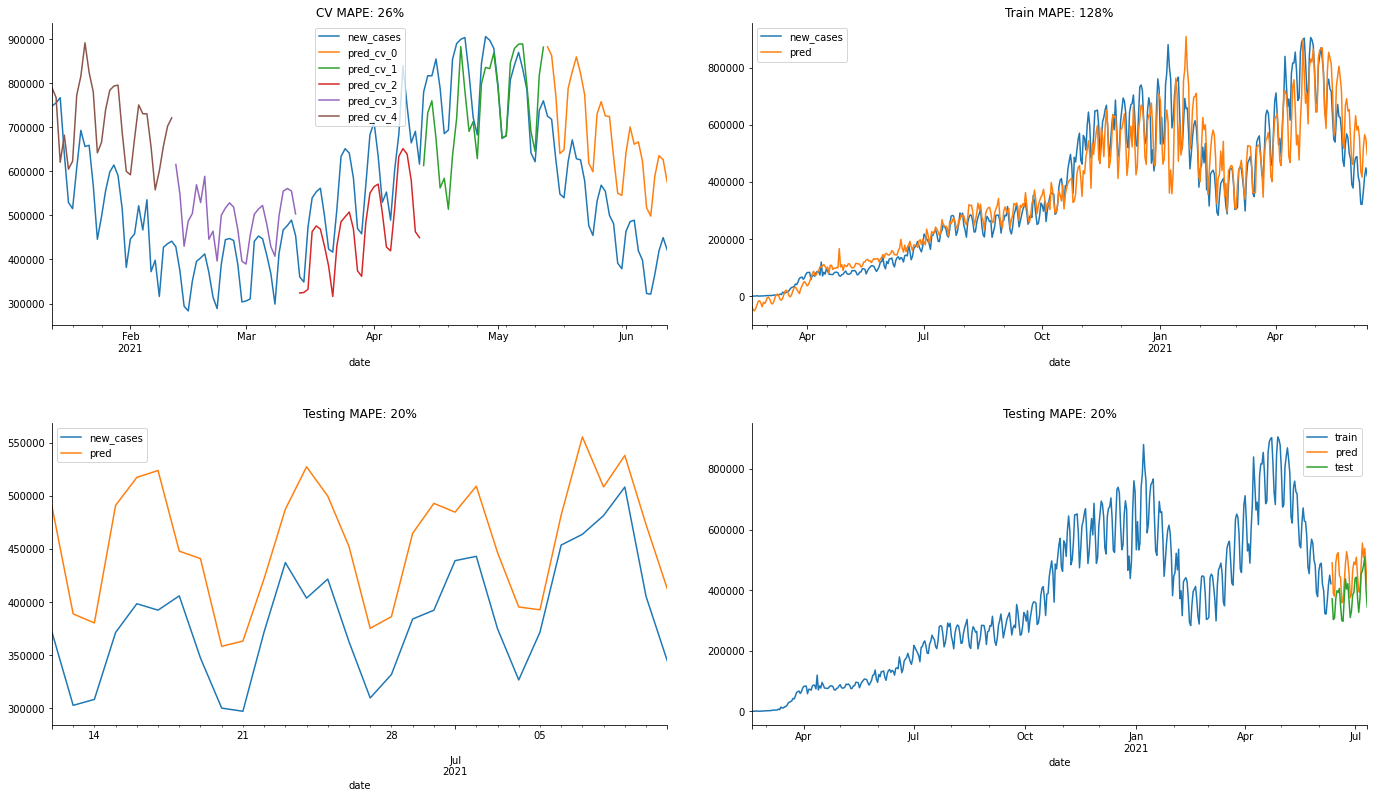

In [25]:
features = [ f'{h}_lag', f'{h}_lag_rolling', 'intercept', 'trend', 'log'] + ['fourier_sin_7_1', 'fourier_cos_7_1']

from sklearn_ts.validator import check_model

from sklearn.linear_model import LinearRegression

params = {'fit_intercept': [False]}
regressor = LinearRegression(fit_intercept=False)

results = check_model(
    regressor, params, X_with_fourier,
    target='new_cases', features=features, categorical_features=[], user_transformers=[],
    h=30, n_splits=5, gap=30,
    plotting=True
)

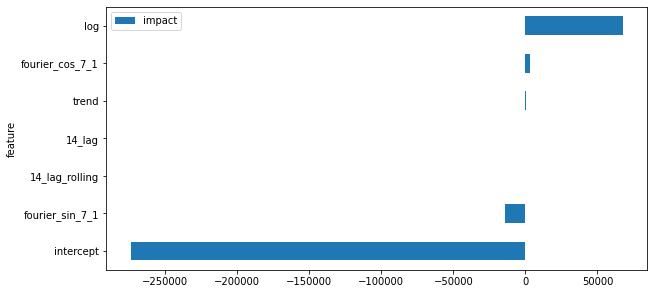

In [34]:
from sklearn_ts.features.explainer import plot_features

plot_features(results['model'], results['features'], figsize=(10, 5));

# Hierarchical

In [35]:
covid.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [36]:
continents = covid['continent'].dropna().unique()

In [37]:
dataset = covid[(covid['location']=='World') | (covid['location'].isin(continents))].copy()[['location', target, 'date']]
dataset['date'] = pd.to_datetime(dataset['date'])
#dataset.index = dataset['date']

In [38]:
dataset.head()

,location,new_cases,date
504,Africa,0.0,2020-02-13
505,Africa,1.0,2020-02-14
506,Africa,0.0,2020-02-15
507,Africa,0.0,2020-02-16
508,Africa,0.0,2020-02-17


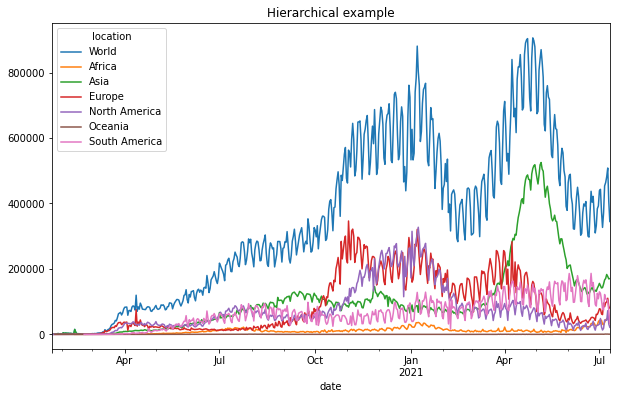

In [39]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
pivoted = pd.pivot_table(dataset, values='new_cases', index='date', columns='location', aggfunc='sum')[['World'] + sorted(list(continents))]
pivoted.plot(title='Hierarchical example', ax=axes)
fig.savefig(f'continents.png')

In [40]:
!pip install scikit-hts

     |████████████████████████████████| 9.5MB 6.5MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [41]:
import hts

In [42]:
pivoted.head()

location,World,Africa,Asia,Europe,North America,Oceania,South America
date,,,,,,,
2020-01-22,0.0,NaN,0.0,NaN,0.0,NaN,NaN
2020-01-23,98.0,NaN,98.0,0.0,0.0,NaN,NaN
2020-01-24,286.0,NaN,283.0,2.0,1.0,NaN,NaN
2020-01-25,492.0,NaN,491.0,1.0,0.0,0.0,NaN
2020-01-26,685.0,NaN,677.0,0.0,4.0,4.0,NaN


In [43]:
# necessary
hierarchy = {'total': list(continents)}
pivoted = pivoted.rename(columns={'World': 'total'})

model_bu_arima = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model_bu_arima = model_bu_arima.fit(pivoted, hierarchy)

Fitting models:   0%|          | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  14%|█▍        | 1/7 [00:03<00:21,  3.55s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  29%|██▊       | 2/7 [00:03<00:12,  2.52s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  43%|████▎     | 3/7 [00:03<00:07,  1.84s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality

Fitting models: 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7f16dac8cbd0>


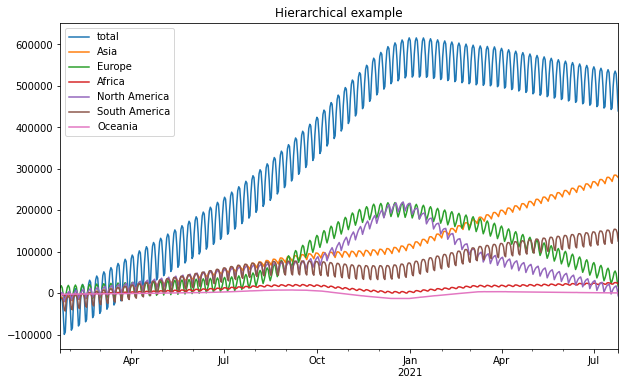

In [44]:
pred_bu_arima = model_bu_arima.predict(steps_ahead=14)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
pred_bu_arima.plot(title='Hierarchical example', ax=axes)
fig.savefig(f'continents_predicted.png')

# Power transform

## Box-Cox

In [45]:
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

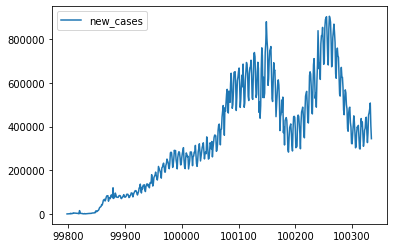

In [50]:
dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = ['intercept', 'trend', 'log', f'{h}_lag_rolling']
lag_features= []

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek

for lag in [h + i for i in range(14)]:
    dataset[f'{lag}_lag'] = dataset[target].shift(lag)
    lag_features.append(f'{lag}_lag')

dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features + categorical_features + lag_features]
dataset = dataset.dropna()

In [51]:
pt = PowerTransformer(method='box-cox')
dataset['box-cox'] = np.squeeze(pt.fit_transform(dataset[['new_cases']]+1))
pt.lambdas_

array([0.60006811])

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[('num', FunctionTransformer(), numerical_features)]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

tt = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer(method='box-cox'))
tt.fit(dataset[numerical_features], dataset[target])

TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('preprocessor',
                                                      ColumnTransformer(n_jobs=None,
                                                                        remainder='drop',
                                                                        sparse_threshold=0.3,
                                                                        transformer_weights=None,
                                                                        transformers=[('num',
                                                                                       FunctionTransformer(accept_sparse=False,
                                                                                                           check_inverse=True,
                                                                              

In [53]:
dataset['pred'] = tt.predict(dataset[numerical_features])

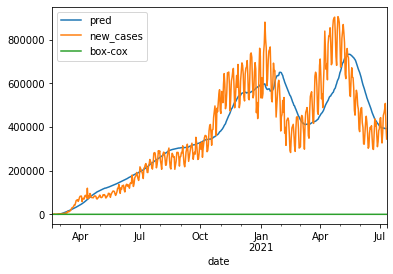

In [54]:
dataset[['pred', 'new_cases', 'box-cox']].plot()

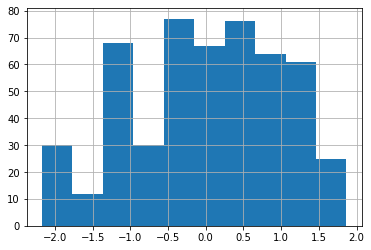

In [55]:
dataset['box-cox'].hist()

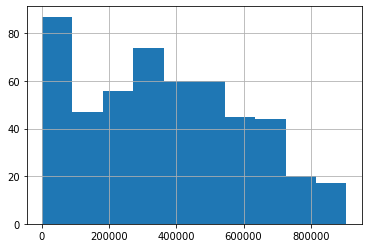

In [56]:
dataset['new_cases'].hist()

In [57]:
tt.regressor.named_steps['regressor']

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
tt.transformer.lambdas_

AttributeError: ignored